# wikipedia election



These data come from a retweet network described here: 

http://networkrepository.com/rt-pol.php

**There is a possible problem with these data: according to the website, the data is undirected.** Examination of the data suggests that this may not be the case, but still, we should proceed with extreme caution and not share anything here until the data format can be confirmed. 

In [1]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation, prep_data
import pandas as pd
%matplotlib inline

In [53]:
path = 'data/soc-wiki-elec/'
t_start = 10

In [64]:
T, timesteps = prep_data.prep_wiki(path, top_n = 500)

n = T.shape[1]
# unclear that this is the right thing to do or why, but not doing so leads to singular behavior. 
# for i in range(T.shape[0]):
#     T[i] = T[i].T

T = T + .001

T, timesteps, A0, n_obs = prep_data.initial_condition(T, timesteps, t_start)

# experimental?




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [65]:
# connectedness issues

T_ = (T[0] + T[0].T) / 2 + .1*np.ones((n,n))
D = np.diag(T_.sum(axis = 1))
L = D - T_
eig = np.linalg.eigh(L)
(eig[0] < 10**(-30)).sum()

0

Next, we'll try to learn the parameters from the data. 

In [69]:
lam_grid = 21 # resolution in $\lambda$
b_grid = 21   # resolution in $\beta$

LAMBDA = np.linspace(0, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(-5, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

# M = estimation.likelihood_surface(T, 
#                                   LAMBDA, 
#                                   BETA, 
#                                   A0, 
#                                   fun = lambda A: SpringRank.SpringRank(A + .001*np.ones((n,n))), 
#                                   alpha = .0001) 

# M_deg = estimation.likelihood_surface(T, 
#                                       LAMBDA, 
#                                       BETA, 
#                                       A0, 
#                                       fun = lambda A: A.sum(axis = 1))

# M_uniform = estimation.likelihood_surface(T, 
#                                       LAMBDA, 
#                                       BETA, 
#                                       A0, 
#                                       fun = lambda A: np.ones(A.shape[0]))

M_pr = estimation.likelihood_surface(T, 
                                      LAMBDA, 
                                      BETA, 
                                      A0, 
                                      fun = lambda A: pageRank(A + .01))

In [70]:
for mat in [M, M_deg, M_uniform, M_pr]:
    print(round(mat.max()/n_obs, 2), estimation.get_estimates(mat, BETA, LAMBDA))

-8.46 {'beta': 0.5, 'lambda': 0.9500000000000001, 's_beta': nan, 's_lambda': nan}
-8.17 {'beta': 0.5, 'lambda': 0.4, 's_beta': 0.0003530387569359472, 's_lambda': 0.04741940770565142}
-8.46 {'beta': -3.5, 'lambda': 0.0, 's_beta': nan, 's_lambda': nan}
-8.16 {'beta': 5.0, 'lambda': 0.0, 's_beta': nan, 's_lambda': nan}


/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/estimation.py:151: RuntimeWarning: invalid value encountered in sqrt
  stderrs = np.sqrt(-np.diag(np.linalg.inv(hessian(M, BETA, LAMBDA)[ix])[0]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1091: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7

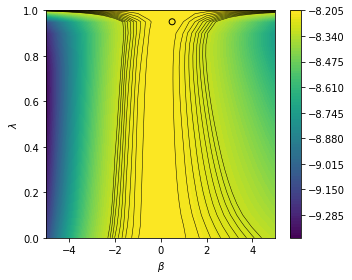

In [22]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M/n_obs, levels = 100)
ax.contour(xg, yg, M/n_obs, 
           levels = np.linspace(M.max()/n_obs - .1, 
                                M.max()/n_obs, 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

hat = estimation.get_estimates(M, BETA, LAMBDA)
beta_hat = hat['beta']
lambda_hat = hat['lambda']

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [29]:
n = T.shape[1]

hat = estimation.get_estimates(M, BETA, LAMBDA)



n_rounds = T.shape[0]


A = estimation.state_matrix(T, hat['lambda'], A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], hat['beta'])
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

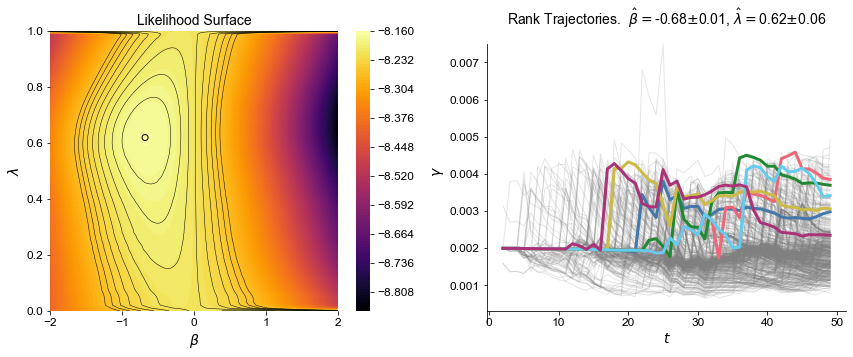

In [30]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


tau = np.arange(timesteps.max())

fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M/n_obs, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M/n_obs, 
           levels = np.linspace((M/n_obs).max()-.1, 
                                (M/n_obs).max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ax1.scatter(hat['beta'], hat['lambda'], color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

k = 0

for l in range(n):
    if l not in top_trajectories:
        ax2.plot(timesteps, GAMMA[:,l], color = 'grey', alpha = .2, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        ax2.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 color = cset[k])
        
       
       
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())


ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories.  $\hat{\beta} = $' + str(round(hat['beta'], 2)) + r'$\pm$' + str(round(2*hat['s_beta'], 2)) + r', $\hat{\lambda} = $' + str(round(hat['lambda'], 2)) + r'$\pm$' + str(round(2*hat['s_lambda'], 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/wiki.png', dpi = 300, bbox_inches = 'tight')